## Computational Finance MScFE 630 GWP Submission 3 - Group 14

### Solution for Question 1

Import all the required libraries for calculations

In [89]:
import pandas as pd
import numpy as np
import scipy.optimize
from scipy.stats import uniform, norm
from matplotlib import pyplot as plt
from matplotlib import style
from scipy import log,exp,sqrt,stats 
from random import gauss

%matplotlib inline
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')


#### 1. Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. You should simulate the values monthly, and should have LIBOR forward rates applying over one month, starting one month apart, up to maturity. You may assume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates. (32 pts)

Input details

In [90]:
# stock parameter values
S = 100.0
v = 0.3
r = 0.08
T = 1.0
K = 100.0
B = 150.0
N = 12

# counterparty firm parameter values
Sf = 200
vf = 0.3
Debt = 175.0
c = 0.2
rr = 0.25
delta_t = T/N

In [91]:
## CLosed form solution (Analytical price) using Vasicek model

def A(t1,t2,alpha):
    return (1-np.exp(-alpha*(t2-t1))) / alpha

def D(t1,t2,alpha,b,sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1 - val2

def bond_price(r,t,T,alpha,b,sigma):
    return np.exp(-A(t,T,alpha)*r +D(t,T,alpha,b,sigma))

# actual zero-coupon bond prices & maturities
zcb_prices = np.array([100,99.38, 
              98.76,98.15,97.54,
              96.94,96.34,95.74,
              95.16,94.57,93.99,
              93.42,92.85])/100.

maturity = np.array([delta_t * n for n in range(N+1)])
# difference between the Vasicek Bond Price and the actual Bond Prices
def F(x):
    r0 = x[0]
    alpha = x[1]
    b = x[2]
    sigma = x[3]
    return np.sum(np.abs(bond_price(r0,0,maturity,alpha,b,sigma) - zcb_prices))

# boundary for parameters
bounds = ((0,0.2),(0,5),(0,0.5),(0,2))

# use the minize function in the Scipy package to calibrate parameters
opt_val = scipy.optimize.fmin_slsqp(F,(0.05,0.3,0.05,0.03),bounds=bounds)
calc_r = opt_val[0]
calc_alpha = opt_val[1]
calc_beta = opt_val[2]
calc_sigma = opt_val[3]


print('\nCalculated values:')
print('Interest rate = {}'.format(calc_r))
print('Alpha = {}'.format(calc_alpha))
print('Beta = {}'.format(calc_beta))
print('Volatility = {}'.format(calc_sigma))

# estimation model bond prices
model_prices = bond_price(calc_r,0,maturity, calc_alpha, calc_beta, calc_sigma)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00024383601983268832
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 11

Calculated values:
Interest rate = 0.07490754544726819
Alpha = 0.27904301286650884
Beta = 0.07065096751860526
Volatility = 0.03642093624527968


In [92]:
model_prices*100.0

array([100.        ,  99.37813391,  98.76100372,  98.14861882,
        97.54098348,  96.93809722,  96.3399552 ,  95.74654857,
        95.15786476,  94.5738878 ,  93.99459863,  93.41997533,
        92.84999337])

We are using predictor-corrector monte carlo simulation instead of a plain monte carlo simulation. The former one has better performance

In [93]:
# Input - Number of simulations
n = 100000

# initialize predictor-corrector Monte Carlo simulation forward rate
predcorr_forward = np.ones([n, N])*(model_prices[:-1]-model_prices[1:])/(delta_t*model_prices[1:])
predcorr_capfac = np.ones([n, N+1])
delta = np.ones([n, N])*delta_t

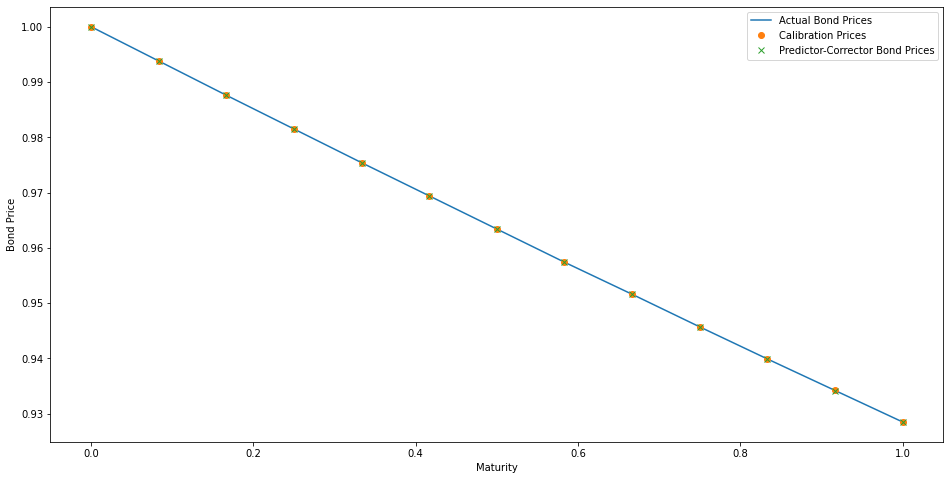

In [94]:
# calculate the forward rate for each steps from the bond price
for i in range(1, N):
    # Pick random number from gaussian distribution
    Z = calc_sigma*sqrt(delta[:,i:])*norm.rvs(size = [n,1])

    # predictor-corrector Monte Carlo simulation
    mu_initial = (np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*calc_sigma**2/
                            (1+delta[:,i:]*predcorr_forward[:,i:]), axis = 1))
    temp = predcorr_forward[:,i:]*exp((mu_initial-calc_sigma**2/2)*delta[:,i:]+Z)
    mu_term = np.cumsum(delta[:,i:]*temp*calc_sigma**2/(1+delta[:,i:]*temp), axis = 1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*exp((mu_initial + mu_term - calc_sigma**2)*delta[:,i:]/2+Z)

# implying capitalization factors from the forward rates
predcorr_capfac[:,1:] = np.cumprod(1+delta*predcorr_forward,axis = 1)

# inverting the capitalization factors to imply bond prices (discount factors)
predcorr_price = predcorr_capfac**(-1)

# taking averages: Forward Rate, Bond Price, Capitalization Factors
# mean Forward Rate
calc_forward_rate = np.mean(predcorr_forward,axis = 0)

# mean Price 
predcorr_price = np.mean(predcorr_price,axis = 0)

# mean Capitalization Factors
calc_capfac = np.mean(predcorr_capfac,axis = 0)

# plot results
plt.subplots(figsize=(16, 8))
plt.xlabel('Maturity')
plt.ylabel('Bond Price')
plt.plot(maturity, zcb_prices, label = 'Actual Bond Prices')
plt.plot(maturity, model_prices, 'o', label = 'Calibration Prices')
plt.plot(maturity, predcorr_price,'x',label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

In [95]:
calc_forward_rate

array([0.0750909 , 0.07498595, 0.07487774, 0.07475829, 0.07463964,
       0.07451499, 0.07438592, 0.07425072, 0.07411338, 0.07397028,
       0.07382609, 0.07367742])

Simulate - LIBOR forward rates, stock paths, counterparty firm values

Use the paramters from the above calculation

In [96]:
stock_paths = [] # stock paths using simulation
firm_paths = []  # firm paths using simulation

def simulate(n = 100000, gamma = 0.75): 
    # Constans calculate outside the loop for optimization
    corr_matrix = np.linalg.cholesky(np.array([[1,c],[c,1]]))
 
    for i in range(n):
        stock_path = []
        firm_path = [] 
        S_j = S
        Sf_j = Sf
        for j in range(N):
            stock_path.append(S_j)
            firm_path.append(Sf_j)
            xi = np.matmul(corr_matrix, stats.norm.rvs(size = 2))

            # local volatilities
            v_dt = v*(S_j)**(gamma-1)
            vf_dt = vf*(Sf_j)**(gamma-1)
            
            # continuously compounded interest rate
            r = np.log(1 + calc_forward_rate[j]*delta_t)/delta_t
            
            # stock price
            S_j *= exp((r-1/2*(v_dt**2))*delta_t + 
                       v_dt*sqrt(delta_t)*xi[0])
            
            # firm price
            Sf_j *= exp((r-1/2*(vf_dt**2))*delta_t + 
                       vf_dt*sqrt(delta_t)*xi[1])
            
        # Saving the stock and firm path
        stock_paths.append(stock_path)
        firm_paths.append(firm_path)

simulate(n)


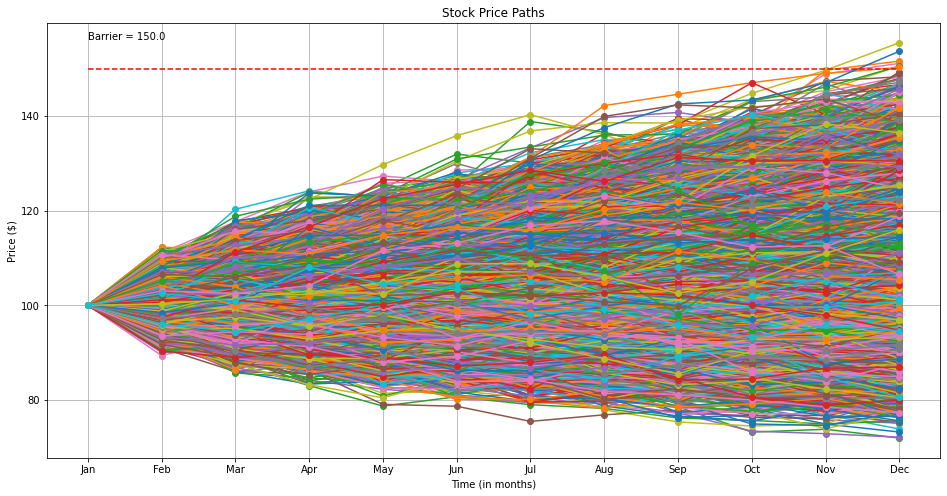

In [97]:
"""Plot stock simulations"""
dates = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(stock_paths, columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.plot([B]*len(dates), linestyle='--', color ='r')
plt.figtext(0.16,0.85,'Barrier = '+ str(B))
plt.title('Stock Price Paths')
plt.xlabel('Time (in months)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

Counter party firm paths

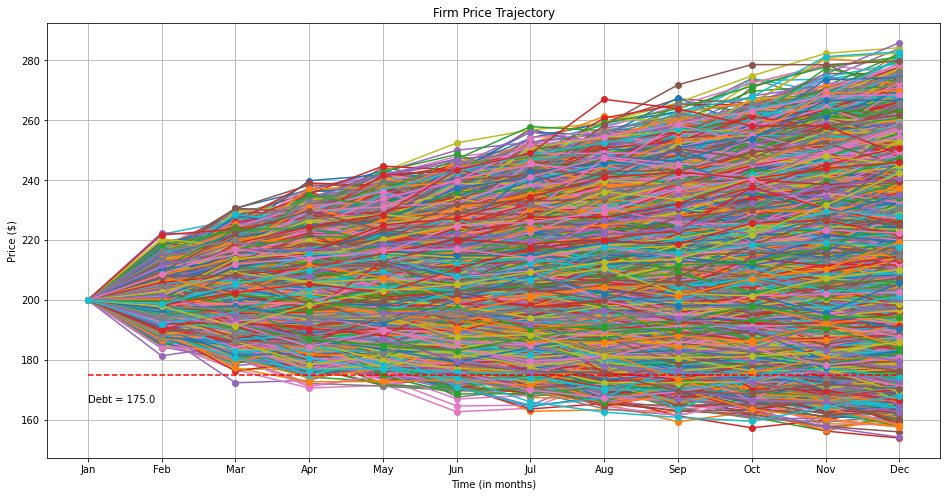

In [98]:
"""Plot firm simulations"""
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(firm_paths, columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.plot([Debt]*len(dates), linestyle='--', color ='r')
plt.figtext(0.16,0.22,'Debt = '+ str(Debt))
plt.title('Firm Price Trajectory')
plt.xlabel('Time (in months)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

### Solution for Question 2

#### Calculate the one-year discount factor which applies for each simulation, and use this to find first the value of the option for the jointly simulated stock and firm paths with no default risk, and then the value of the option with counterparty default risk. (32 pts)

Continuously compounded interest rates

In [99]:
r_sim = np.log(1 + predcorr_forward*delta_t)/delta_t
r_sim

array([[0.07485693, 0.07614214, 0.07563986, ..., 0.07617244, 0.07575892,
        0.07601377],
       [0.07485693, 0.07506146, 0.07596396, ..., 0.07312996, 0.07361304,
        0.07432557],
       [0.07485693, 0.07551802, 0.07529863, ..., 0.07306912, 0.0727583 ,
        0.07312622],
       ...,
       [0.07485693, 0.07531839, 0.07573008, ..., 0.07713325, 0.07633884,
        0.075565  ],
       [0.07485693, 0.07383794, 0.07293879, ..., 0.07605531, 0.07660264,
        0.07606142],
       [0.07485693, 0.07374716, 0.07336699, ..., 0.07257093, 0.07347509,
        0.07459168]])

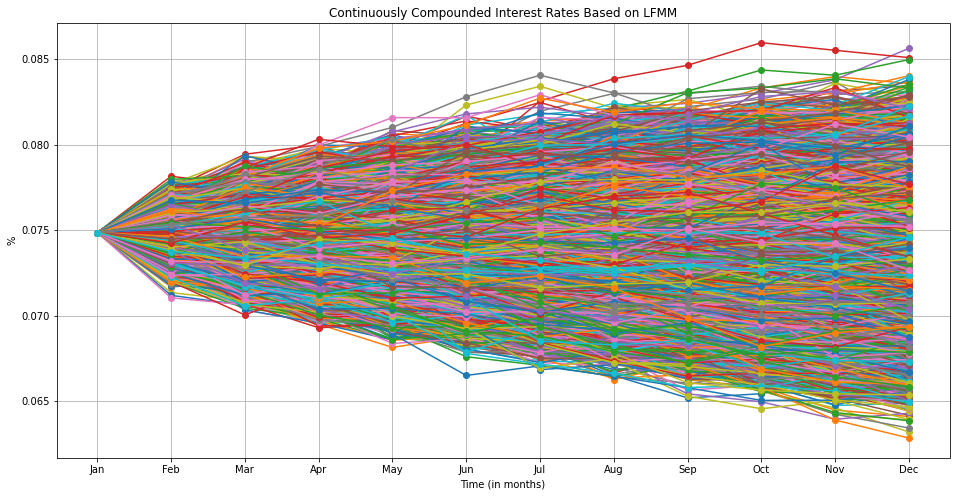

In [100]:
"""Plot interest rate simulations""" 
plt.subplots(figsize=(16, 8))
paths = pd.DataFrame(r_sim, columns = dates)
for index, row in paths.iterrows():
    plt.plot(row, marker='o')

plt.title('Continuously Compounded Interest Rates Based on LFMM')
plt.xlabel('Time (in months)')
plt.ylabel('%')
plt.grid(True)
plt.show()

One year discount factors

In [101]:
capfac_r_sim = np.cumprod(1 + delta_t*r_sim, axis = 1)
discfac_r_sim = capfac_r_sim**(-1)

discfac_1y = discfac_r_sim[:, -1]
discfac_1y

array([0.92701989, 0.92824836, 0.92847842, ..., 0.92666556, 0.9280432 ,
       0.92922043])

Default-free UAO call value

In [102]:
def uao_call_disc_payoffs(price_paths, discfacs, strike, barrier):
    disc_payoffs = np.zeros([n, 2])
    price_paths = np.array(price_paths)
    path_no = -1
    
    for path in price_paths:
        path_no += 1
        if sum((path >= barrier)) == 0:
            disc_payoffs[path_no, 0] = np.maximum(path[-1] - strike, 0) * discfacs[path_no]
            disc_payoffs[path_no, 1] = 1
            
    return disc_payoffs

In [103]:
disc_payoffs = uao_call_disc_payoffs(stock_paths, discfac_1y, K, B)

In [104]:
uao_call_meanval = np.mean(np.extract(disc_payoffs[:, 1] == 1, disc_payoffs[:, 0]))
uao_call_stderr = np.std(np.extract(disc_payoffs[:, 1] == 1, disc_payoffs[:, 0]))/np.sqrt(np.sum(disc_payoffs[:, 1]))

print('Default-free European UAO Call Value:', uao_call_meanval.round(3))
print('Default-free European UAO Call Std. Error:', uao_call_stderr.round(3))

Default-free European UAO Call Value: 7.677
Default-free European UAO Call Std. Error: 0.023


Default-adjusted UAO call value

In [105]:
#CVA estimate
Sf_T = np.column_stack((np.array(firm_paths)[:, -1], disc_payoffs[:, 1]))

#We only calculate the loss for those price paths where the call is activated, i.e. barrier is not breached
loss = (np.extract(disc_payoffs[:, 1] == 1, disc_payoffs[:, 0]) * (np.extract(Sf_T[:, 1] == 1, Sf_T[:, 0]) < Debt) *
        (1 - rr))

cva_meanval = np.mean(loss)
cva_stderror = np.std(loss)/np.sqrt(np.sum(disc_payoffs[:, 1]))

print('CVA Mean Value:', cva_meanval.round(3))
print('CVA Std. Error:', cva_stderror.round(3))
print(' ')
print('Default-adj UAO Call Value:', (uao_call_meanval - cva_meanval).round(3))

CVA Mean Value: 0.015
CVA Std. Error: 0.001
 
Default-adj UAO Call Value: 7.662


### Solution for Question 4

#### Suppose interest rates increased 25 basis points. What is the new value of your option? (4 pts)

In [106]:
r_sim_plus25bps = r_sim + 0.0025
r_sim_plus25bps

array([[0.07735693, 0.07864214, 0.07813986, ..., 0.07867244, 0.07825892,
        0.07851377],
       [0.07735693, 0.07756146, 0.07846396, ..., 0.07562996, 0.07611304,
        0.07682557],
       [0.07735693, 0.07801802, 0.07779863, ..., 0.07556912, 0.0752583 ,
        0.07562622],
       ...,
       [0.07735693, 0.07781839, 0.07823008, ..., 0.07963325, 0.07883884,
        0.078065  ],
       [0.07735693, 0.07633794, 0.07543879, ..., 0.07855531, 0.07910264,
        0.07856142],
       [0.07735693, 0.07624716, 0.07586699, ..., 0.07507093, 0.07597509,
        0.07709168]])

In [107]:
capfac_r_sim_plus25bps = np.cumprod(1 + delta_t*r_sim_plus25bps, axis = 1)
discfac_r_sim_plus25bps = capfac_r_sim_plus25bps**(-1)

discfac_1y_plus25bps = discfac_r_sim_plus25bps[:, -1]
discfac_1y_plus25bps

array([0.92472003, 0.9259452 , 0.92617464, ..., 0.92436664, 0.92574058,
       0.92691465])

Default-free UAO call value after Interest Rate Increase

In [108]:
disc_payoffs_plus25bps = uao_call_disc_payoffs(stock_paths, discfac_1y_plus25bps, K, B)

In [109]:
uao_call_meanval_plus25bps = np.mean(np.extract(disc_payoffs_plus25bps[:, 1] == 1, disc_payoffs_plus25bps[:, 0]))
uao_call_stderr_plus25bps = (np.std(np.extract(disc_payoffs_plus25bps[:, 1] == 1, disc_payoffs_plus25bps[:, 0]))/
                             np.sqrt(np.sum(disc_payoffs_plus25bps[:, 1])))

print('Default-free European UAO Call Value after Interest Rate Increase:', uao_call_meanval_plus25bps.round(3))
print('Default-free European UAO Call Std. Error after Interest Rate Increase:', uao_call_stderr_plus25bps.round(3))

Default-free European UAO Call Value after Interest Rate Increase: 7.658
Default-free European UAO Call Std. Error after Interest Rate Increase: 0.023


Default-adjusted UAO call value after Interest Rate Increase

In [110]:
#CVA estimate
Sf_T_plus25bps = np.column_stack((np.array(firm_paths)[:, -1], disc_payoffs_plus25bps[:, 1]))

#We only calculate the loss for those price paths where the call is activated, i.e. barrier is not breached
loss_plus25bps = (np.extract(disc_payoffs_plus25bps[:, 1] == 1, disc_payoffs_plus25bps[:, 0]) * 
                  (np.extract(Sf_T_plus25bps[:, 1] == 1, Sf_T_plus25bps[:, 0]) < Debt) * (1 - rr))

cva_meanval_plus25bps = np.mean(loss_plus25bps)
cva_stderror_plus25bps = np.std(loss_plus25bps)/np.sqrt(np.sum(disc_payoffs_plus25bps[:, 1]))

print('CVA Mean Value after Interest Rate Increase:', cva_meanval_plus25bps.round(3))
print('CVA Std. Error after Interest Rate Increase:', cva_stderror_plus25bps.round(3))
print(' ')
print('Default-adj UAO Call Value after Interest Rate Increase:', (uao_call_meanval_plus25bps - 
                                                                   cva_meanval_plus25bps).round(3))

CVA Mean Value after Interest Rate Increase: 0.015
CVA Std. Error after Interest Rate Increase: 0.001
 
Default-adj UAO Call Value after Interest Rate Increase: 7.643
